In [1]:
pip install codecarbon --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 53.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 3.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.21.1 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.
firebase-admin 6.9.0 requires httpx[http2]==0.28.1, but you have httpx 0.27.2 which is incompatible.
langchain-core 0.3.66 requires packaging<25,>=23.2, but you have packaging 25.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


[INFO] Loading dataset...


/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[INFO] Training LightGBM model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24735
[LightGBM] [Info] Number of data points in the train set: 4502, number of used features: 97
[LightGBM] [Info] Start training from score -1.386739
[LightGBM] [Info] Start training from score -1.385850
[LightGBM] [Info] Start training from score -1.386739
[LightGBM] [Info] Start training from score -1.385850
[INFO] Selected features shape: (4502, 49)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12495
[LightGBM] [Info] Number of data points in the train set: 4502, number of used features: 49
[LightGBM] [Info] Start training from score -1.386739
[LightGBM] [Info] Start training from score -1.385850
[LightGBM] [Info] Sta

[codecarbon WARNING @ 16:47:15] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 16:47:15] [setup] RAM Tracking...
[codecarbon INFO @ 16:47:15] [setup] CPU Tracking...
[codecarbon WARNING @ 16:47:16] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 16:47:16] CPU Model on constant consumption mode: AMD EPYC 7B12
[codecarbon WARNING @ 16:47:16] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 16:47:16] [setup] GPU Tracking...
[codecarbon INFO @ 16:47:16] No GPU found.
[codecarbon INFO @ 16:47:16] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 16:47:16] >>> Tracker's m


🔧 Training Time: 21.64 m.seconds
🔋 Energy Emissions: 0.246757 mg CO₂


=== Classification Report ===
                 precision    recall  f1-score   support

backgroundnoise       0.49      0.68      0.57       282
 brokenbranches       0.79      0.68      0.73       281
      footsteps       0.76      0.72      0.74       282
        gunshot       0.68      0.55      0.61       281

       accuracy                           0.66      1126
      macro avg       0.68      0.66      0.66      1126
   weighted avg       0.68      0.66      0.66      1126


=== Confusion Matrix ===
[[193  20  25  44]
 [ 59 192  19  11]
 [ 52  11 203  16]
 [ 87  19  21 154]]

=== AUC Scores ===
backgroundnoise: AUC = 0.824
brokenbranches: AUC = 0.903
footsteps: AUC = 0.903
gunshot: AUC = 0.841


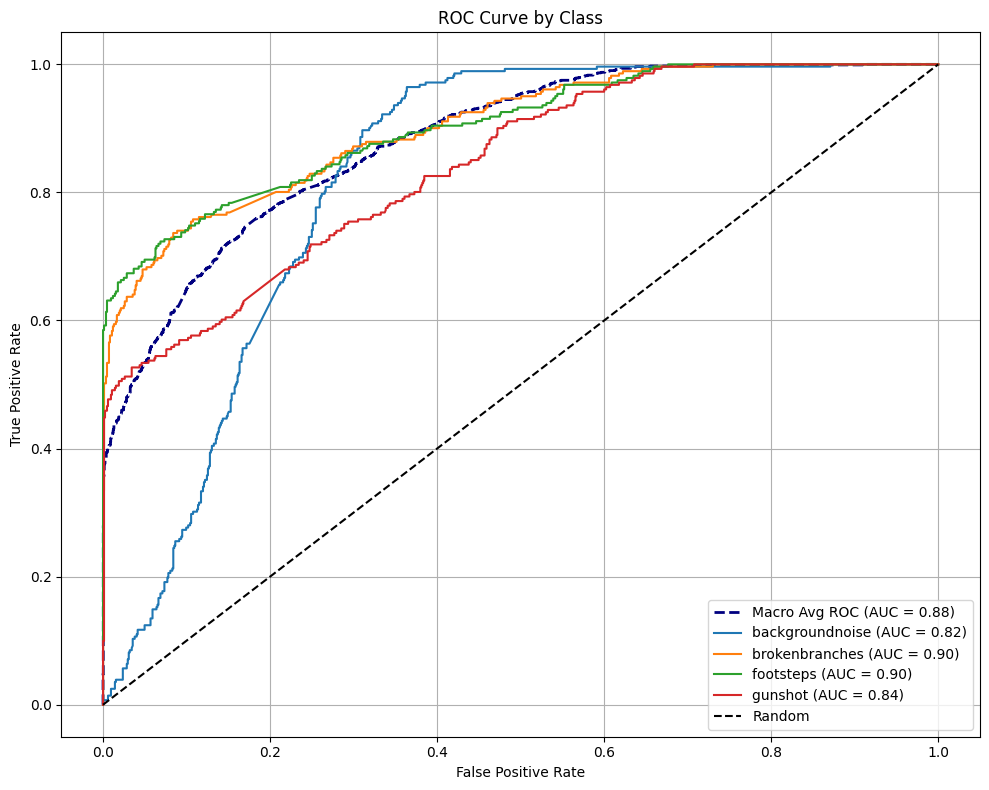

In [2]:
import os
import numpy as np
import librosa
import time
import lightgbm as lgb
import matplotlib.pyplot as plt
from codecarbon import EmissionsTracker
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc
)

# === 1. Feature Extraction ===
def extract_features_with_pcen_static(file_path, sr=16000, duration=1, n_mels=64, n_mfcc=13):
    y, _ = librosa.load(file_path, sr=sr)
    y = librosa.util.fix_length(y, size=int(sr * duration))

    # === PCEN ===
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    pcen = librosa.pcen(mel_spec, sr=sr, gain=0.8, bias=10, power=0.25, time_constant=0.06, eps=1e-6)
    pcen_mean = np.mean(pcen, axis=1)

    # === MFCCs ===
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)

    # === Spectral Contrast ===
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    contrast_mean = np.mean(contrast, axis=1)

    # === Zero-Crossing Rate ===
    zcr = librosa.feature.zero_crossing_rate(y)
    zcr_mean = np.mean(zcr)

    # === Chroma Features ===
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)

    # === Combine all ===
    feature_vector = np.concatenate([pcen_mean, mfcc_mean, contrast_mean, [zcr_mean], chroma_mean])

    return feature_vector


# === 2. Load Dataset from Folder ===
def load_dataset_static_pcen(folder_path):
    X, y = [], []
    for fname in os.listdir(folder_path):
        if fname.endswith(".wav"):
            label = fname.split("_")[0]
            file_path = os.path.join(folder_path, fname)
            try:
                features = extract_features_with_pcen_static(file_path)
                X.append(features)
                y.append(label)
            except Exception as e:
                print(f"Skipping {fname}: {e}")
    return np.array(X), np.array(y)

# === 3. Plot ROC Curves ===
def plot_roc(y_true, y_score, class_names):
    y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["macro"], tpr["macro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(10, 8))
    plt.plot(fpr["macro"], tpr["macro"], label=f"Macro Avg ROC (AUC = {roc_auc['macro']:.2f})", color='navy', linestyle='--', linewidth=2)

    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve by Class")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === 4. Main with Separate Train/Test Folders ===
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

def main(folder_path):
    print("[INFO] Loading dataset...")
    X, y = load_dataset_static_pcen(folder_path)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)

    # Split data (recommended)
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    # === Initial LightGBM Model ===
    model = lgb.LGBMClassifier()
    print("[INFO] Training LightGBM model...")
    model.fit(X_train, y_train)

    # === Feature Selection ===
    selector = SelectFromModel(model, prefit=True, threshold="median")  # Keep top 50% by default
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)

    print(f"[INFO] Selected features shape: {X_train_selected.shape}")

    # === Retrain with selected features ===
    model_selected = lgb.LGBMClassifier()
    model_selected.fit(X_train_selected, y_train)

    # === Track Energy + Time ===
    tracker = EmissionsTracker(project_name="Full_LGBM_4_Classes")
    tracker.start()
    start_time = time.time()
    
    y_pred = model_selected.predict(X_test_selected)

    train_time = time.time() - start_time
    emissions = tracker.stop()

    y_proba = model_selected.predict_proba(X_test_selected)

    print(f"\n🔧 Training Time: {train_time*1000:.2f} m.seconds")
    print(f"🔋 Energy Emissions: {emissions*1000000:.6f} mg CO₂\n")

    print("\n=== Classification Report ===")
    print(classification_report(y_test, y_pred, target_names=encoder.classes_))

    print("\n=== Confusion Matrix ===")
    print(confusion_matrix(y_test, y_pred))

    print("\n=== AUC Scores ===")
    for i, class_name in enumerate(encoder.classes_):
        auc_score = roc_auc_score((y_test == i).astype(int), y_proba[:, i])
        print(f"{class_name}: AUC = {auc_score:.3f}")

    # Plot ROC curves
    plot_roc(y_test, y_proba, encoder.classes_)

    return model_selected, scaler, encoder, selector

# === 5. Run It ===
if __name__ == "__main__":
    train_folder = "/kaggle/input/stage2/data/train"  # e.g., "data/train"
    test_folder = "/kaggle/input/stage2/data/test"    # e.g., "data/test"
    model, scaler, encoder, selector = main(train_folder)
